In [21]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import os
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from IPython.display import Image
from keras import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Flatten, GlobalAveragePooling2D
import tf_keras
from tensorflow.keras.callbacks import EarlyStopping
import os
#os.environ['TF_USE_LEGACY_KERAS'] = '1'
from tensorflow.keras.layers import Layer, Concatenate, Input

from sklearn.metrics import accuracy_score

from keras.models import Model

## Load Data

In [2]:
%%capture
import zipfile
!unzip /content/CIFAKE.zip

In [3]:
dataset_dir = "train"
img_height = 32
img_width = 32
batch_size = 500

# Load training and validation data
train, val = keras.utils.image_dataset_from_directory(
  os.path.join(dataset_dir, ""),
  validation_split=0.2,
  subset="both",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = 80000)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Using 20000 files for validation.


In [4]:
test = keras.utils.image_dataset_from_directory(
  os.path.join("test"),
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = 20000)

Found 20000 files belonging to 2 classes.


In [5]:
train_list = list(train)
train_imgs = train_list[0][0].numpy()
train_labels = train_list[0][1].numpy()
norm_train_imgs = train_imgs/255.0
norm_train_imgs.shape

(80000, 32, 32, 3)

In [6]:
val_list = list(val)
val_imgs = val_list[0][0].numpy()
val_labels = val_list[0][1].numpy()
norm_val_imgs = val_imgs/255.0
val_labels.shape

(20000,)

In [7]:
test_list = list(test)
test_imgs = test_list[0][0].numpy()
test_labels = test_list[0][1].numpy()
norm_test_imgs = test_imgs/255.0
norm_test_imgs.shape

(20000, 32, 32, 3)

## CNN

In [8]:
keras.backend.clear_session()

cnn_model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(units=512, activation="relu"),
    layers.Dense(units=1, activation="sigmoid")])

## AlexNet Architecture

In [9]:
alex_model = Sequential([
    layers.Rescaling(1./255, input_shape=(32,32,3)),
    layers.Resizing(227,227),
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
alex_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 resizing (Resizing)         (None, 227, 227, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 27, 27, 256)      

## VGG

In [11]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

def preprocess(x, y):
    return preprocess_input(x), y

trainv = train.map(preprocess)
valv = val.map(preprocess)
testv = test.map(preprocess)

trainv_list = list(trainv)
trainv_imgs = trainv_list[0][0].numpy()
trainv_labels = trainv_list[0][1].numpy()

valv_list = list(valv)
valv_imgs = valv_list[0][0].numpy()
valv_labels = valv_list[0][1].numpy()

testv_list = list(testv)
testv_imgs = testv_list[0][0].numpy()
testv_labels = testv_list[0][1].numpy()


vgg = VGG16(include_top=False, input_shape=(32, 32, 3))
vgg.trainable = False
vggmodel = Sequential([
    vgg,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(units=1024, activation="relu"),
    layers.Dense(units=1, activation="sigmoid")])

58889256/58889256 [==============================] - 2s 0us/step


## Ensemble Model

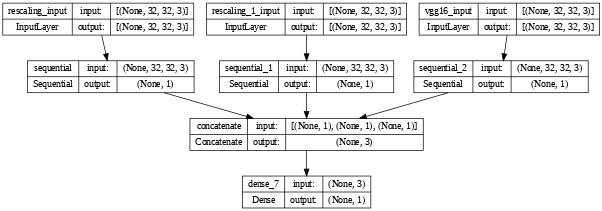

In [12]:
input1 = cnn_model.input
input2 = alex_model.input
input3 = vggmodel.input

m1 = cnn_model(input1)
m2 = alex_model(input2)
m3 = vggmodel(input3)

output = tf.keras.layers.Concatenate()([m1,m2,m3])
output = tf.keras.layers.Dense(1, activation='sigmoid')(output)
final_model = tf.keras.Model(inputs=[input1,input2,input3], outputs=output, name="ensembled")

tf.keras.utils.plot_model(final_model, show_shapes=True, dpi=50)

In [13]:
es = EarlyStopping(monitor="val_accuracy",
                   patience=5,
                   restore_best_weights=True,
                   verbose=1)
final_model.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy", metrics.Precision(name="precision"), metrics.Recall(name="recall")])


history = final_model.fit(
	x=[train_imgs, train_imgs, trainv_imgs], y=train_labels,
	validation_data=([val_imgs, val_imgs, valv_imgs], val_labels),
	epochs=40, verbose=3, callbacks=[es])
history = pd.DataFrame(history.history)
display(history)

Epoch 1/40
Epoch 2/40
Epoch 3/40
Epoch 4/40
Epoch 5/40
Epoch 6/40
Epoch 7/40
Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping


,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,0.693418,0.500437,0.500276,0.454095,0.693348,0.49010,0.234783,0.008088
1,0.693179,0.499675,0.499372,0.407903,0.693154,0.50075,0.500750,1.000000
2,0.693183,0.496075,0.496301,0.551957,0.693164,0.49925,0.500000,0.000100
3,0.693178,0.498287,0.497553,0.386420,0.693147,0.50075,0.500750,1.000000
4,0.693156,0.502150,0.501789,0.550581,0.693160,0.49925,0.000000,0.000000
5,0.693182,0.497800,0.496656,0.354683,0.693149,0.50075,0.500750,1.000000
6,0.693168,0.501450,0.501292,0.489884,0.693185,0.49925,0.000000,0.000000


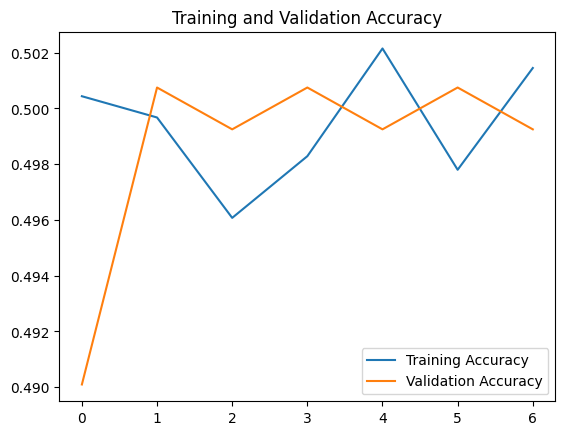

In [14]:
plt.plot(range(len(history)), history["accuracy"], label="Training Accuracy")
plt.plot(range(len(history)), history["val_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.show()

In [15]:
preds = final_model.predict([val_imgs, val_imgs, valv_imgs])

625/625 [==============================] - 5s 7ms/step


In [20]:
sum(preds > 0.5)

array([20000])

In [22]:
final_model.evaluate([test_imgs, test_imgs, testv_imgs], test_labels, return_dict=True)

625/625 [==============================] - 5s 8ms/step - loss: 0.6931 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000


{'loss': 0.6931458711624146, 'accuracy': 0.5, 'precision': 0.5, 'recall': 1.0}